In [2]:
import os
from dotenv import load_dotenv

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from datetime import datetime, timezone

load_dotenv()

True

In [10]:
# os.getenv("BNB_KEY")

tickers = ['ETHEUR', 'BNBEUR']
interval = "1d"
start = datetime(2022, 1, 1)
end = datetime(2026, 1, 27)

url = "https://api.binance.com/api/v3/klines"

columns = [
    "open_time",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "close_time",
    "quote_volume",
    "num_trades",
    "taker_base_volume",
    "taker_quote_volume",
    "ignore"
]

data = pd.DataFrame()

In [11]:
for ticker in tickers:
    params = {
        "symbol": ticker,
        "interval": interval,
        "startTime": int(start.timestamp() * 1000),
        "endTime": int(end.timestamp() * 1000),
    }
    res = requests.get(url, params)
    print(res, res.text)
    if res.status_code == 200:
        
        df = pd.DataFrame(res.json(), columns=columns)
        df['time'] = pd.to_datetime(df['open_time'], unit = 'ms', utc = True)
        df['close'] = pd.to_numeric(df['close'], errors = 'raise')

        data[f'{ticker}_time'] = df['time']
        data[f'{ticker}_px'] = df['close']

<Response [200]> [[1641081600000,"3318.20000000","3394.11000000","3276.75000000","3370.05000000","8893.22190000",1641167999999,"29637640.79053800",33579,"4801.96590000","16010940.26392200","0"],[1641168000000,"3370.45000000","3398.13000000","3261.51000000","3332.50000000","13218.55740000",1641254399999,"44143931.72346700",44650,"7116.37210000","23768514.39460800","0"],[1641254400000,"3332.46000000","3447.86000000","3286.64000000","3356.89000000","15329.84760000",1641340799999,"51723295.09698600",51863,"8222.90150000","27747380.81120300","0"],[1641340800000,"3356.89000000","3405.00000000","3028.88000000","3135.67000000","24881.36430000",1641427199999,"81089092.02935500",79095,"13038.31620000","42555589.56203100","0"],[1641427200000,"3135.65000000","3145.85000000","2922.00000000","3019.23000000","28640.94810000",1641513599999,"86645255.68016900",92012,"15695.40060000","47492192.32917700","0"],[1641513600000,"3018.93000000","3027.67000000","2705.97000000","2818.97000000","40856.20310000",

<h5 style="color:red"> PRACTICE THE DATA CLEANING CHAPTER </h5>

In [49]:
data

,ETHEUR_time,ETHEUR_px,BNBEUR_time,BNBEUR_px
0,2022-01-02 00:00:00+00:00,3370.05,2022-01-02 00:00:00+00:00,467.5
1,2022-01-03 00:00:00+00:00,3332.50,2022-01-03 00:00:00+00:00,452.9
2,2022-01-04 00:00:00+00:00,3356.89,2022-01-04 00:00:00+00:00,449.9
3,2022-01-05 00:00:00+00:00,3135.67,2022-01-05 00:00:00+00:00,420.0
4,2022-01-06 00:00:00+00:00,3019.23,2022-01-06 00:00:00+00:00,418.8
...,...,...,...,...
495,2023-05-12 00:00:00+00:00,1668.88,2023-05-12 00:00:00+00:00,284.8
496,2023-05-13 00:00:00+00:00,1662.91,2023-05-13 00:00:00+00:00,287.8
497,2023-05-14 00:00:00+00:00,1664.22,2023-05-14 00:00:00+00:00,288.6
498,2023-05-15 00:00:00+00:00,1676.03,2023-05-15 00:00:00+00:00,289.4


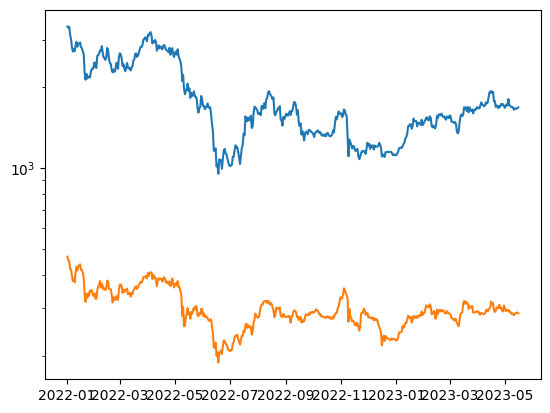

In [13]:
for ticker in tickers:
    plt.plot(data[f'{ticker}_time'], data[f'{ticker}_px'], label = f'{ticker}')

plt.yscale('log')

In [58]:
x = data["ETHEUR_px"]
y = data["BNBEUR_px"]

stat, pval, crit = coint(y, x, trend = 'c', maxlag = 1, autolag = None)

print("Engle–Granger CADF via coint")
print("stat:", stat)
print("p-value:", pval)
print("crit:", crit)

Engle–Granger CADF via coint
stat: -3.7732870271313095
p-value: 0.014708410293045033
crit: [-3.91852234 -3.34840209 -3.05296032]


In [46]:
X = sm.add_constant(x)
model = sm.OLS(y, X)
reg = model.fit()
hedge_ratio = reg.params[1]
hedge_ratio

/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/ipykernel_8662/1667605926.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = reg.params[1]


np.float64(0.07983430191136093)

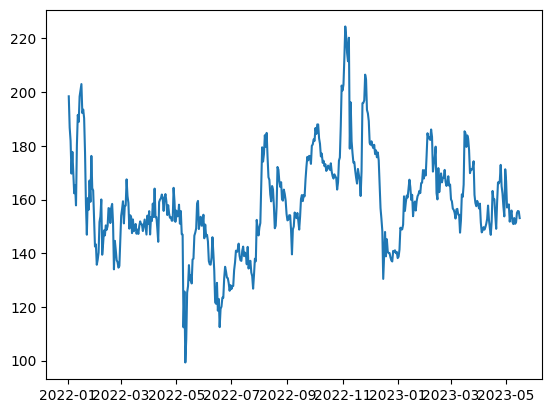

In [16]:
spread = y - hedge_ratio * x # stationary residuals

plt.plot(data['BNBEUR_time'], spread)

In [62]:
y2 = np.column_stack([y, x])

jres = coint_johansen(y2, 0, 1)

print("Trace statistics:", jres.trace_stat)
print("Trace crit values (90, 95, 99%):\n", jres.trace_stat_crit_vals)

print("Max-eig statistics:", jres.max_eig_stat)
print("Max-eig crit values (90, 95, 99%):\n", jres.max_eig_stat_crit_vals)

Trace statistics: [21.78350709  5.1820186 ]
Trace crit values (90, 95, 99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-eig statistics: [16.60148849  5.1820186 ]
Max-eig crit values (90, 95, 99%):
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [63]:
print('Eigenvalues:')
print(jres.eig)

print('Eigenvectors:')
print(jres.evec)

beta = jres.evec[:, 0]

Eigenvalues:
[0.03278679 0.01035171]
Eigenvectors:
[[ 0.04983573 -0.02498959]
 [-0.00317972  0.00354209]]


In [64]:
tmp = beta[1] / beta[0]
tmp

np.float64(-0.06380400673286521)

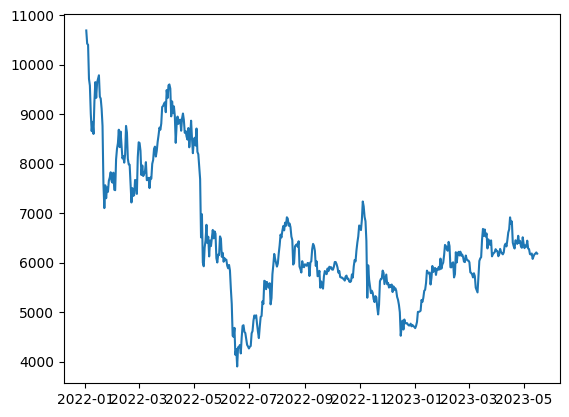

In [60]:
tmp_spred = x - y * tmp

plt.plot(data['BNBEUR_time'], tmp_spred)

In [ ]:
ff = pd.read_csv("data/ff_monthly.csv")
ff["Date"] = pd.to_datetime(ff["Date"], format = "%Y%m")
ff.set_index("Date", inplace = True)

# mkt = ff['Mkt-RF'] / 100

# ff.head()

In [2]:
# ticker = "BTC-USD.CC"
# url = f'https://eodhd.com/api/eod/{ticker}?api_token={os.getenv("EODHD_KEY")}&order=d&fmt=json'
# r = requests.get(url)
# r.text

'[{"date":"2026-01-27","open":88261.03125,"high":88333.46875,"low":88111,"close":88331.4375,"adjusted_close":88331.4375,"volume":42900553728},{"date":"2026-01-26","open":86566.5229094044,"high":88743.0696927182,"low":86429.2927831311,"close":88267.1367579689,"adjusted_close":88267.1367579689,"volume":45329286974},{"date":"2026-01-25","open":89104.765625,"high":89193.1484375,"low":86003.7109375,"close":86572.21875,"adjusted_close":86572.21875,"volume":36124986722},{"date":"2026-01-24","open":89506.1484375,"high":89811.609375,"low":89044.2890625,"close":89110.734375,"adjusted_close":89110.734375,"volume":14558687712},{"date":"2026-01-23","open":89462.046875,"high":91100.25,"low":88486.359375,"close":89503.875,"adjusted_close":89503.875,"volume":38997586037},{"date":"2026-01-22","open":89378.5234375,"high":90258.9609375,"low":88438.4453125,"close":89462.453125,"adjusted_close":89462.453125,"volume":35549685694},{"date":"2026-01-21","open":88326.5078125,"high":90430.40625,"low":87231.57031

In [3]:
data = pd.DataFrame(r.json())
data

,date,open,high,low,close,adjusted_close,volume
0,2026-01-27,88261.031250,88333.468750,88111.000000,88331.437500,88331.437500,42900553728
1,2026-01-26,86566.522909,88743.069693,86429.292783,88267.136758,88267.136758,45329286974
2,2026-01-25,89104.765625,89193.148438,86003.710938,86572.218750,86572.218750,36124986722
3,2026-01-24,89506.148438,89811.609375,89044.289062,89110.734375,89110.734375,14558687712
4,2026-01-23,89462.046875,91100.250000,88486.359375,89503.875000,89503.875000,38997586037
...,...,...,...,...,...,...,...
361,2025-01-31,104737.562192,106026.350288,101543.882914,102405.027084,102405.027084,45732764360
362,2025-01-30,103709.338799,106418.766695,103321.645064,104735.302839,104735.302839,41915744521
363,2025-01-29,101317.527253,104750.807242,101283.822710,103703.211192,103703.211192,47432049818
364,2025-01-28,102095.417583,103730.821061,100238.188137,101332.476221,101332.476221,47180685494


<Axes: >

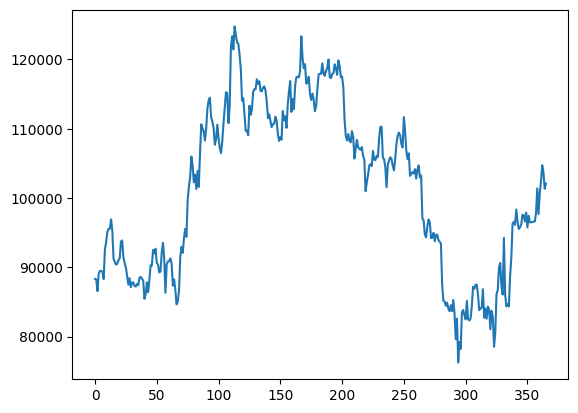

In [5]:
close = data['close']
close.plot()

In [9]:
adfuller(close)

(np.float64(-1.8321333088129708),
 np.float64(0.3646290865469106),
 0,
 365,
 {'1%': np.float64(-3.4483935212959844),
  '5%': np.float64(-2.8694912343676497),
  '10%': np.float64(-2.571005879151811)},
 np.float64(6313.274249223951))

In [11]:
from hurst import compute_Hc

H, C, data_hurst = compute_Hc(close, kind = "price", simplified = True)
H

np.float64(0.5956441535571179)